In [1]:
import hssm
import arviz as az
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import jax

/users/yzhao313/hssm_test/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model fitting

In [ ]:
n_subjects = 40  # number of subjects
n_trials = 100  # number of trials per subject - vary from low to high values to check shrinkage
sd_v = 0.3  # sd for v-intercept
sd_a = 0.3  # sd for v-intercept
mean_v = 1.25  # mean for v-intercept
mean_vx = 0.8 # mean for slope of x onto v
mean_vy = 0.2 # mean for slope of x onto v

sd_t=0.1
sd_z=0.1
mean_a = 1.5
mean_t = 0.5
mean_z = 0.5
data_list = []
param_list =[]
for i in range(n_subjects):
    # Make parameters for subject i
    intercept = np.random.normal(mean_v, sd_v, size=1)
    x = np.random.uniform(-1, 1, size=n_trials)
    y = np.random.uniform(-1, 1, size=n_trials)
    v_x = np.random.normal(mean_vx, sd_v, size=1)
    v_y = np.random.normal(mean_vy, sd_v, size=1)
    v = intercept + (v_x * x) + (v_y * y)
    a = np.random.normal(mean_a, sd_a, size=1)
    z = np.random.normal(mean_z, sd_z, size=1)
    t = np.random.normal(mean_t, sd_t, size=1)

# v is a vector which differs over trials by x and y, so we have different v for every trial - other params are same for all trials
    true_values = np.column_stack(
     [v, np.repeat(a, axis=0, repeats=n_trials), np.repeat(z, axis=0, repeats=n_trials), np.repeat(t, axis=0, repeats=n_trials)]
)
    # Simulate data
    obs_ddm_reg_v = hssm.simulate_data(model="ddm", theta=true_values, size=1)
   # store ground truth params
    param_list.append(
       pd.DataFrame(
           {
               "v_Intercept": intercept,
               "v_x": v_x,
               "v_y": v_y,
               "a": a,
               "z": z,
               "t": t,
               "subject": i
            }
       )
       )
    # Append simulated data to list
    data_list.append(
        pd.DataFrame(
            {
                "rt": obs_ddm_reg_v["rt"],
                "response": obs_ddm_reg_v["response"],
                "x": x,
                "y": y,
                "subject": i,
            }
        )
    )
# Make single dataframe out of subject-wise datasets
dataset_reg_v_hier_full = pd.concat(data_list)
dataset_reg_v_hier_full

In [ ]:
dataset_reg_v_hier_full.to_csv('HSSM/data/dataset_reg_v_hier_full.csv', index=False)

In [ ]:
model_reg_v_ddm_hier1A = hssm.HSSM(
    data=dataset_reg_v_hier_full,
    model="ddm",
    loglik_kind="analytical",  # approx_differentiable = LAN likelihood; analytical = Navarro & Fuss
    prior_settings="safe",
    p_outlier=0, # remove the p_outlier for now due to a current bug in HSSM
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + x + y + (1 + x + y | subject)",
            "prior": {
                "Intercept": {"name": "Normal", "mu": 1, "sigma": 2, "initval": 1},
                "x": {"name": "Normal", "mu": 0, "sigma": 1, "initval": 0},
                "y": {"name": "Normal", "mu": 0, "sigma": 1, "initval": 0},
                "1|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 1}, "initval": 0.5},
                "x|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 0.5}, "initval": 0.5},
                "y|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 0.5}, "initval": 0.5}
            },
            "link": "identity",
        },
        {
            "name": "t",
            "formula": "t ~ 1 + (1 | subject)",
            "prior": {
                "Intercept": {"name": "Normal", "mu": 0.5, "sigma": 0.4, "initval": 0.3},
                "1|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 0.5}, "initval": 0.1}
            },
            "link": "identity",
        },
        {
            "name": "z",
            "formula": "z ~ 1 + (1 | subject)",
            "prior": {
                "Intercept": {"name": "HalfNormal", "sigma": 1, "initval": 0.5},
                "1|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 0.05}, "initval": 0.01}
            },
        },
        {
            "name": "a",
            "formula": "a ~ 1 + (1 | subject)",
            "prior": {
                "Intercept": {"name": "Gamma", "mu": 0.5, "sigma": 1.75, "initval": 1},
                "1|subject": {"name": "Normal", "mu": 0, "sigma": {"name": "HalfNormal", "sigma": 1}, "initval": 0.3}
            },
        },
    ]
)

# print the model
model_reg_v_ddm_hier1A

In [ ]:
samples_model_reg_v_ddm_hier1A = model_reg_v_ddm_hier1A.sample(
    sampler="nuts_numpyro",  # type of sampler to choose, 'nuts_numpyro', 'nuts_blackjax' of default pymc nuts sampler
    cores=3,  # how many cores to use
    chains=3,  # how many chains to run
    draws=200,  # number of draws from the markov chain
    tune=200,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
)

In [ ]:
# Save
samples_model_reg_v_ddm_hier1A.to_netcdf('HSSM/outputs/model_1')

## Check posterior

In [2]:
# Load
samples_model_reg_v_ddm_hier1A = az.InferenceData.from_netcdf('HSSM/outputs/model_1')

In [3]:
samples_model_reg_v_ddm_hier1A

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [4]:
az.summary(samples_model_reg_v_ddm_hier1A, var_names=["v_Intercept", "v_x", "v_y", "v_1|subject_sigma", "v_x|subject_sigma","v_y|subject_sigma", "a_1|subject_sigma", "a_Intercept", "t_Intercept", "z_Intercept", "t_1|subject_sigma", "z_1|subject_sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_Intercept,1.065,0.034,0.998,1.126,0.001,0.001,629.0,435.0,1.00
v_x,0.713,0.058,0.603,0.816,0.003,0.002,278.0,378.0,1.01
v_y,0.151,0.036,0.090,0.227,0.002,0.001,474.0,447.0,1.00
v_1|subject_sigma,0.139,0.034,0.074,0.200,0.002,0.002,197.0,461.0,1.01
v_x|subject_sigma,0.301,0.043,0.225,0.384,0.003,0.002,208.0,333.0,1.01
v_y|subject_sigma,0.176,0.038,0.098,0.241,0.002,0.002,275.0,421.0,1.00
a_1|subject_sigma,0.256,0.036,0.185,0.323,0.003,0.002,212.0,245.0,1.00
a_Intercept,1.485,0.041,1.404,1.560,0.003,0.002,206.0,313.0,1.02
t_Intercept,0.485,0.017,0.456,0.517,0.001,0.001,296.0,354.0,1.01
z_Intercept,0.531,0.018,0.499,0.563,0.001,0.001,197.0,261.0,1.00


/users/yzhao313/hssm_test/.venv/lib/python3.11/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (16) is smaller than the number of variables to plot (22), generating only 16 plots
  warnings.warn(


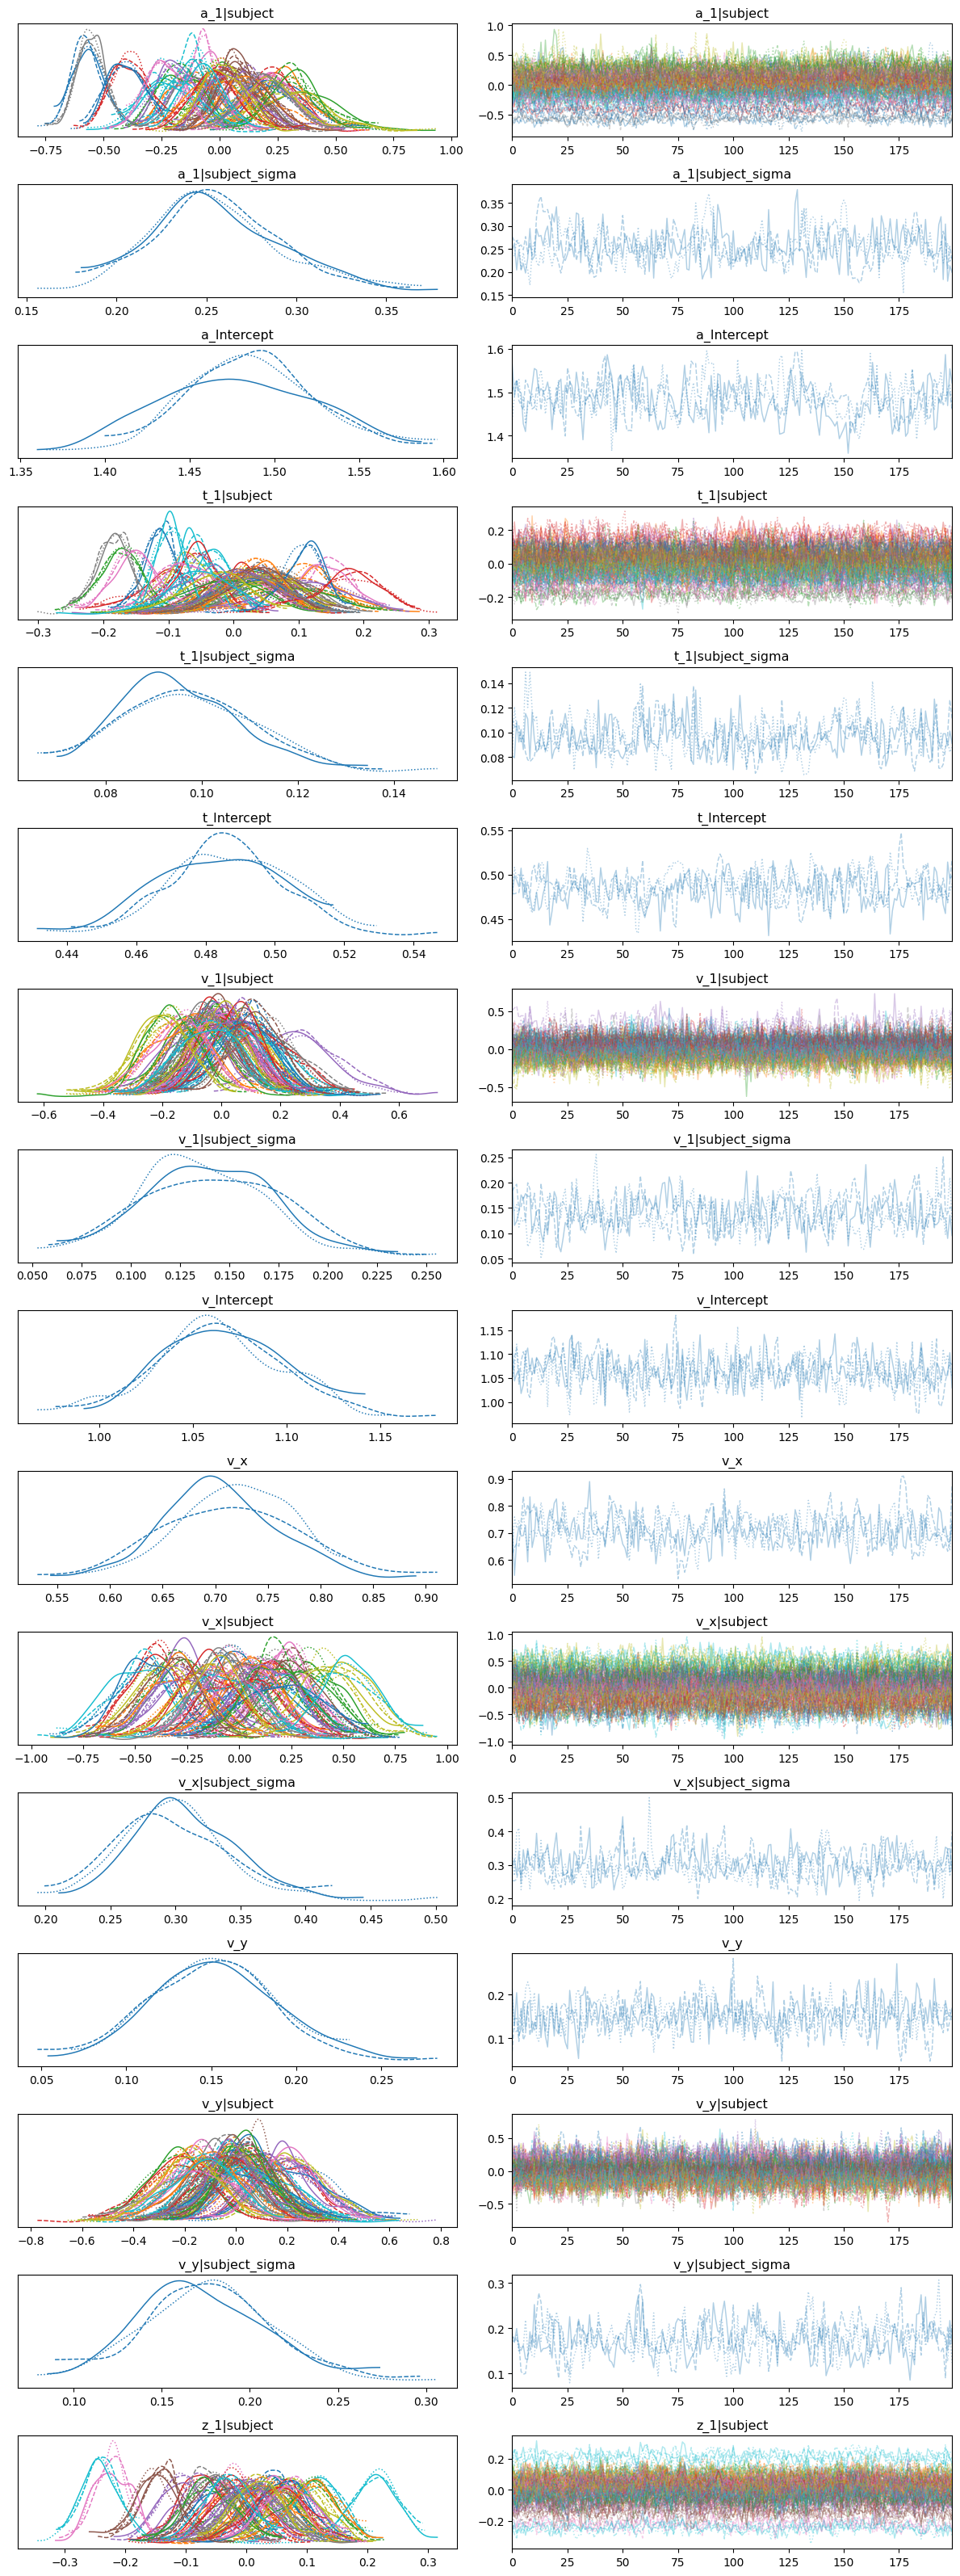

In [5]:
az.rcParams["plot.max_subplots"] = 32
az.plot_trace(samples_model_reg_v_ddm_hier1A)
plt.tight_layout()
plt.show()